In [137]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [138]:
# Load the dataset
df = pd.read_csv('../Data/pre_ADA-USD.csv')

In [139]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Days_Since_Start
0,0.311973,0.311973,0.288392,0.304397,0.304397,184691008,0
1,0.304424,0.307058,0.288875,0.293504,0.293504,107240000,1
2,0.292952,0.309129,0.292507,0.297106,0.297106,115320000,2
3,0.296285,0.303588,0.286193,0.300787,0.300787,94436000,3
4,0.299897,0.317723,0.291055,0.297622,0.297622,202675008,4


In [140]:
df= df.drop(columns=["Open", "High", "Low", "Adj Close","Volume"])
df = df.rename(columns={'Close': 'Price'})
df = pd.DataFrame(data=df)
data = df

In [141]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train, test = data.iloc[:split_index], data.iloc[split_index:]

In [142]:
# Bước 1: Tạo các mô hình dự báo có sẵn
def forecast_arima(train, steps):
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def forecast_random_forest(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = RandomForestRegressor()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

def forecast_linear_regression(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = LinearRegression()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast



In [143]:
# Bước 2: Tạo các dự báo từ mỗi mô hình
steps_test = len(test)
# Train ARIMA model
arima_model = ARIMA(train['Price'], order=(1, 1, 1))
arima_result = arima_model.fit()
# Predict with ARIMA
arima_pred = arima_result.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
rf_test_forecast = forecast_random_forest(train, steps_test)
linear_test_forecast = forecast_linear_regression(train, steps_test)

c:\Users\kakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [144]:
# Bước 3: Áp dụng kỹ thuật Bagging cho từng mô hình
# Bagging cho RandomForest và LinearRegression
bagging_rf = BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=10, random_state=42)
bagging_linear = BaggingRegressor(estimator=LinearRegression(), n_estimators=10, random_state=42)

# Huấn luyện mô hình Bagging
bagging_rf.fit(X_train, y_train)
bagging_linear.fit(X_train, y_train)

# Dự báo từ mô hình Bagging
X_pred = np.arange(len(data), len(data) + steps_test).reshape(-1, 1)

rf_bagging_forecast = bagging_rf.predict(X_pred)
linear_bagging_forecast = bagging_linear.predict(X_pred)


In [145]:
# Bước 4: Kết hợp các dự báo cuối cùng
final_forecast = (arima_pred + rf_bagging_forecast + linear_bagging_forecast) / 3

# # Đánh giá mô hình
# mae = mean_absolute_error(data['Price'], final_forecast)
# rmse = np.sqrt(mean_squared_error(data['Price'], final_forecast))

# print(f'Mean Absolute Error: {mae}')
# print(f'Root Mean Squared Error: {rmse}')

ValueError: x and y must have same first dimension, but have shapes (2285,) and (457,)

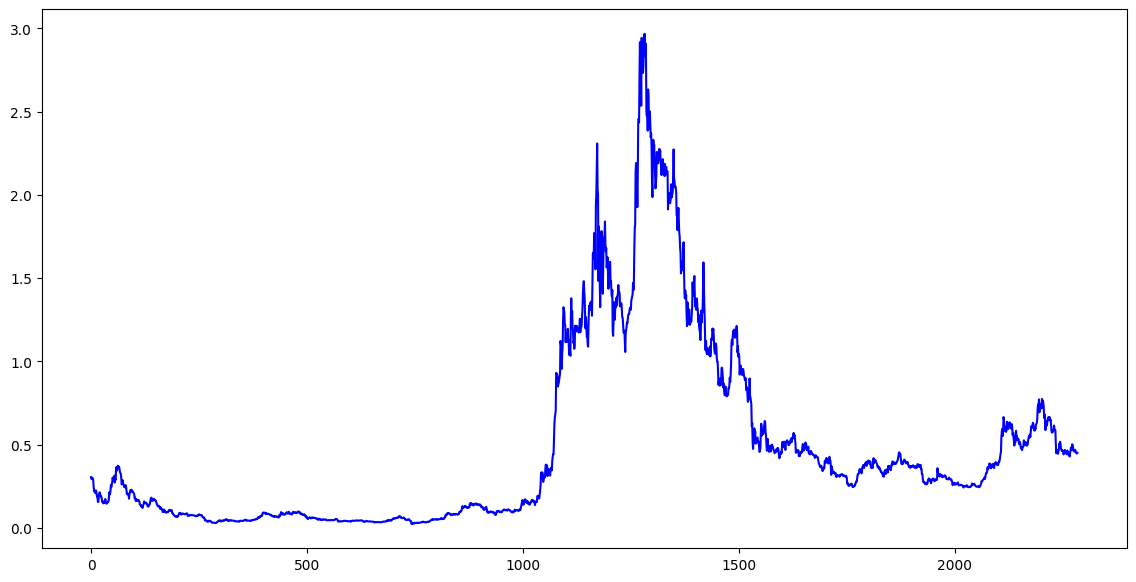

In [146]:
# Vẽ biểu đồ giá trị thực tế và dự báo
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Price'], label='Actual Price', color='blue')
plt.plot(data.index, arima_test_forecast[:len(data)], label='ARIMA Forecast', color='green', linestyle='--')
plt.plot(data.index, rf_bagging_forecast[:len(data)], label='Bagging RandomForest Forecast', color='orange', linestyle='--')
plt.plot(data.index, linear_bagging_forecast[:len(data)], label='Bagging Linear Regression Forecast', color='purple', linestyle='--')
plt.plot(data.index, final_forecast[:len(data)], label='Final Ensemble Forecast', color='red')

plt.title('Coin Price Prediction using Ensemble Bagging')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

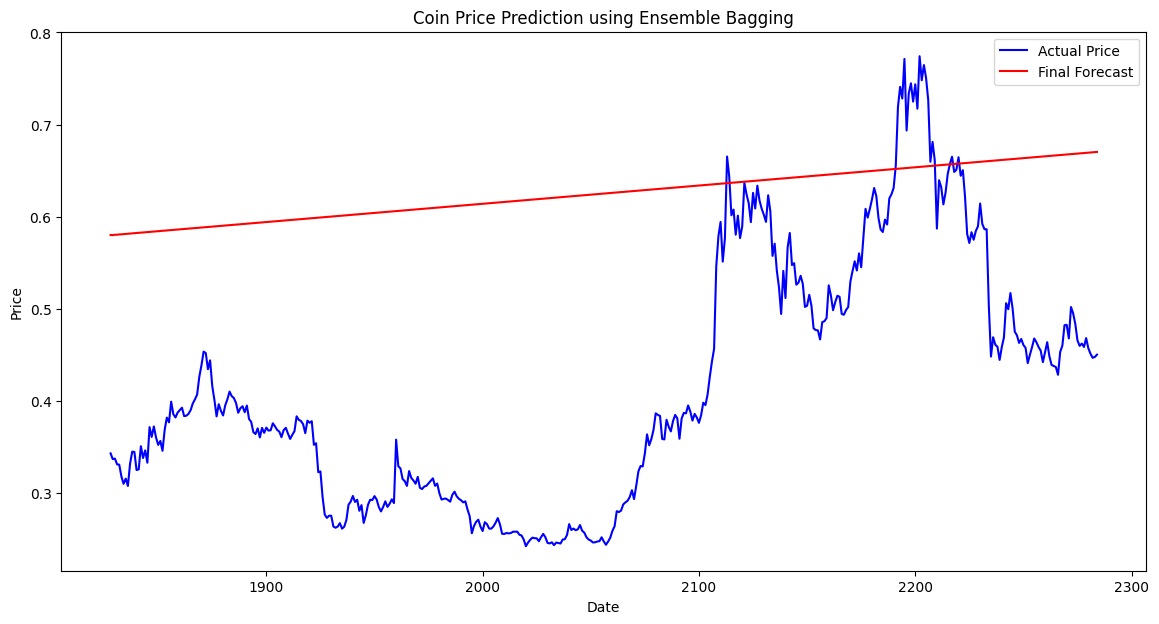

In [ ]:
# Vẽ biểu đồ giá trị thực tế và dự báo
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Price'], label='Actual Price', color='blue')
plt.plot(data.index, final_forecast, label='Final Forecast', color='red')
plt.plot(data.index, arima_pred, label='ARIMA Forecast', color='black')
plt.plot(data.index, linear_bagging_forecast, label='linear Forecast', color='pink')
plt.plot(data.index, rf_bagging_forecast, label='Random Forest Forecast', color='green')

plt.title('Coin Price Prediction using Ensemble Bagging')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2285,) and (457,)

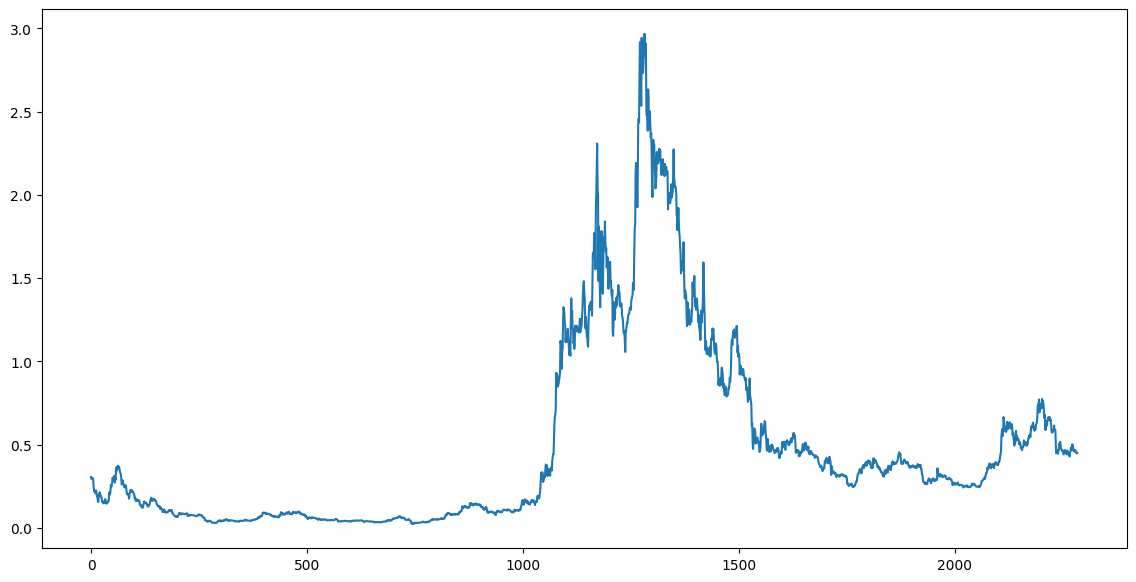

In [ ]:
# Plot the predictions for all data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Price'], label='Actual Price')
#plt.plot(data.index, arima_pred, color='black', label='ARIMA Prediction')
# plt.plot(data.index, rf_pred, color='green', label='Random Forest Prediction')
plt.plot(data.index, final_forecast, color='red', label='Ensemble Prediction')
plt.plot(data.index, linear_test_forecast, color='purple', label='Linear Prediction')
#plt.plot(data.index, dt_pred, color='green', label='Decision Tree Prediction')


# Highlight the last 30, 60, 90 days predictions
plt.axvspan(test.index[-30], test.index[-1], color='yellow', alpha=0.3, label='Last 30 Days')
plt.axvspan(test.index[-60], test.index[-30], color='orange', alpha=0.3, label='Last 60 Days')
plt.axvspan(test.index[-90], test.index[-60], color='pink', alpha=0.3, label='Last 90 Days')


plt.legend()
plt.title('Price Prediction with ARIMA and Random Forest Ensemble')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()